In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from ydf import RandomForestLearner, GradientBoostedTreesLearner
import ydf

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

CPU times: user 3.94 s, sys: 708 ms, total: 4.65 s
Wall time: 7.13 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s5e4/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s5e4/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (750000, 11)
The dimension of the test dataset is: (250000, 10)
CPU times: user 1.14 s, sys: 350 ms, total: 1.49 s
Wall time: 2.18 s


# Data Exploration

First, we start by visualizing the target feature.

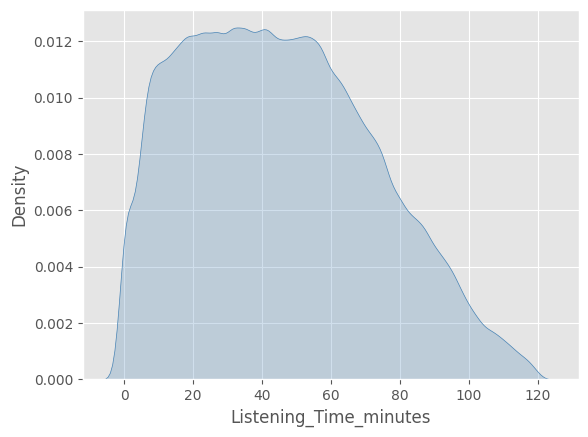

In [3]:
sns.kdeplot(data=train, x="Listening_Time_minutes", fill=True, color="steelblue")
plt.show();

The above chart shows that `Listening_Time_minutes` is slightly right-skewed. Next, we take a deep dive into the datasets.

In [4]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [5]:
test.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [6]:
podcast_num = train["Podcast_Name"].nunique()
print(f"There are {podcast_num} podcast names in the train dataset.")

There are 48 podcast names in the train dataset.


Next, we proceed to check if the same `Podcast_Name` values appear in the `train` and `test` datasets.

In [7]:
np.sum(~np.isin(test["Podcast_Name"].unique().tolist(), train["Podcast_Name"].unique().tolist()))

0

The above shows all the `Podcast_Name` from the `test` dataset appear in the `train` dataset. Next, we explore the `Number_of_Ads`.

In [8]:
print("Train Data: Number_of_Ads Frequency Table\n")
print(train["Number_of_Ads"].value_counts())
print("\n")
print("Test Data: Number_of_Ads Frequency Table\n")
print(test["Number_of_Ads"].value_counts())

Train Data: Number_of_Ads Frequency Table

Number_of_Ads
0.00      217592
1.00      214069
3.00      160173
2.00      158156
103.25         2
53.37          1
103.00         1
103.91         1
53.42          1
103.75         1
12.00          1
103.88         1
Name: count, dtype: int64


Test Data: Number_of_Ads Frequency Table

Number_of_Ads
0.00       72863
1.00       71015
3.00       53556
2.00       52564
89.12          1
2063.00        1
Name: count, dtype: int64


From the above tables, we notice a few unusual values for `Number_of_Ads`. Next, we explore `Host_Popularity_percentage`. 

In [9]:
print("Train Data: Host_Popularity_percentage Summary Statistics\n")
print(train["Host_Popularity_percentage"].describe())
print("\n")
print("Test Data: Host_Popularity_percentage Summary Statistics\n")
print(test["Host_Popularity_percentage"].describe())

Train Data: Host_Popularity_percentage Summary Statistics

count    750000.000000
mean         59.859901
std          22.873098
min           1.300000
25%          39.410000
50%          60.050000
75%          79.530000
max         119.460000
Name: Host_Popularity_percentage, dtype: float64


Test Data: Host_Popularity_percentage Summary Statistics

count    250000.000000
mean         59.716491
std          22.880028
min           2.490000
25%          39.250000
50%          59.900000
75%          79.390000
max         117.760000
Name: Host_Popularity_percentage, dtype: float64


From the above tables, we notice a few unusual values (greater than 100) for `Host_Popularity_percentage`. Next, we explore `Guest_Popularity_percentage`.

In [10]:
print("Train Data: Guest_Popularity_percentage Summary Statistics\n")
print(train["Guest_Popularity_percentage"].describe())
print("\n")
print("Test Data: Guest_Popularity_percentage Summary Statistics\n")
print(test["Guest_Popularity_percentage"].describe())

Train Data: Guest_Popularity_percentage Summary Statistics

count    603970.000000
mean         52.236449
std          28.451241
min           0.000000
25%          28.380000
50%          53.580000
75%          76.600000
max         119.910000
Name: Guest_Popularity_percentage, dtype: float64


Test Data: Guest_Popularity_percentage Summary Statistics

count    201168.000000
mean         52.192796
std          28.445034
min           0.000000
25%          28.320000
50%          53.360000
75%          76.560000
max         116.820000
Name: Guest_Popularity_percentage, dtype: float64


From the above tables, we notice a few unusual values (greater than 100) for `Guest_Popularity_percentage`. Next, we start exploring potential relationships between the input features and the target.

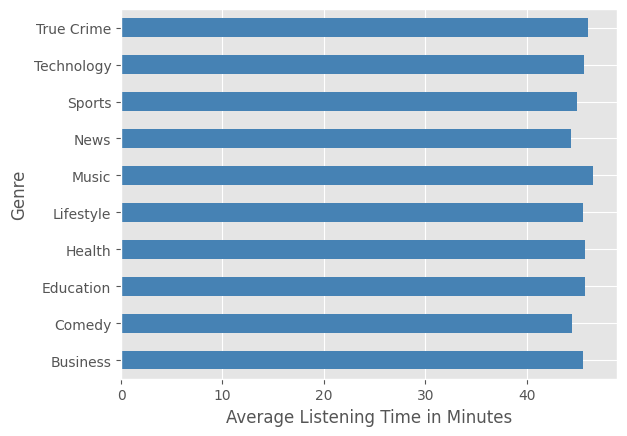

In [11]:
train.groupby("Genre")["Listening_Time_minutes"].mean().plot(kind="barh", color="steelblue")
plt.xlabel("Average Listening Time in Minutes")
plt.show();

The chart does not indicate significant differences in average listening times across podcast genres.

# Data Processing 

In [12]:
%%time
train["Number_of_Ads"] = np.clip(train["Number_of_Ads"], None, 3)  
train["Number_of_Ads"] = train["Number_of_Ads"].fillna(0).astype(int)  
train["Host_Popularity_percentage"] = np.clip(train["Host_Popularity_percentage"], 0, 100)
train["Guest_Popularity_percentage"] = np.clip(train["Guest_Popularity_percentage"], 0, 100)

test["Number_of_Ads"] = np.clip(test["Number_of_Ads"], None, 3)  
test["Host_Popularity_percentage"] = np.clip(test["Host_Popularity_percentage"], 0, 100)
test["Guest_Popularity_percentage"] = np.clip(test["Guest_Popularity_percentage"], 0, 100)

CPU times: user 45.3 ms, sys: 0 ns, total: 45.3 ms
Wall time: 44.9 ms


# Baseline Modeling 1.0

In this section, we build a straightforward model with raw data as follows.

In [13]:
%%time
cat_features = ['Podcast_Name',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

X = train.drop(columns=["Episode_Title", "Listening_Time_minutes"], axis=1)
test = test.drop(columns=["Episode_Title"], axis=1)

for col in cat_features:
    X[col] = X[col].astype("category")
    test[col] = test[col].astype("category")

y = train["Listening_Time_minutes"]

skf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

scores, test_preds = [], []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    d_train = Pool(X_train, y_train, cat_features=cat_features)
    d_val = Pool(X_val, y_val, cat_features=cat_features)

    model = CatBoostRegressor(iterations=3000, 
                              learning_rate=0.05,
                              l2_leaf_reg=0.05,
                              depth=10,
                              eval_metric='RMSE',
                              random_seed=42,
                              verbose=0, 
                              task_type="GPU")
    model.fit(d_train, eval_set=d_val, early_stopping_rounds=150)
    y_pred = model.predict(X_val)
    test_pred = model.predict(test)
    score = np.sqrt(np.mean((y_val - y_pred) ** 2))
    scores.append(score)
    print(f"Fold {i+1} RMSE: {score:.4f}")
    
    test_preds.append(test_pred)

print(f"Mean RMSE: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Fold 1 RMSE: 12.9924
Fold 2 RMSE: 12.9607
Fold 3 RMSE: 13.0100
Fold 4 RMSE: 13.0432
Fold 5 RMSE: 12.9790
Fold 6 RMSE: 13.0377
Fold 7 RMSE: 12.9689
Fold 8 RMSE: 13.0707
Fold 9 RMSE: 12.9280
Fold 10 RMSE: 13.0439
Mean RMSE: 13.0035 ± 0.0429
CPU times: user 30min 28s, sys: 2min 26s, total: 32min 55s
Wall time: 24min 15s


In [14]:
%%time
submission = pd.read_csv("../input/playground-series-s5e4/sample_submission.csv")
submission["Listening_Time_minutes"] = np.mean(test_preds, axis=0)
submission.head()

CPU times: user 46.3 ms, sys: 9.03 ms, total: 55.3 ms
Wall time: 88.2 ms


,id,Listening_Time_minutes
0,750000,55.136847
1,750001,18.262732
2,750002,50.345157
3,750003,78.716680
4,750004,48.389376


In [15]:
%%time
submission.to_csv("baseline_sub_1.csv", index=False)

CPU times: user 391 ms, sys: 18.8 ms, total: 410 ms
Wall time: 410 ms
